In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from pmdarima import auto_arima
import warnings
warnings.filterwarnings("ignore")

In [7]:
df = pd.read_excel("BaseFeaturesHH.xlsx")
df.index = pd.to_datetime(df['From Timestamp'])
df.drop(columns=['From Timestamp','Unnamed: 0'],inplace=True)

df

,HH Electricity (kWh),dayofweek,hour,holiday,month,Temperature (C),Feels like (C),Humidity (%)
From Timestamp,,,,,,,,
2018-01-01 00:00:00,12.80,0,0.0,1,1,6.4,1.9,82.76
2018-01-01 00:30:00,12.30,0,0.5,1,1,6.4,1.9,82.76
2018-01-01 01:00:00,13.50,0,1.0,1,1,6.6,2.4,80.14
2018-01-01 01:30:00,11.90,0,1.5,1,1,6.6,2.4,80.14
2018-01-01 02:00:00,12.80,0,2.0,1,1,6.1,2.0,84.33
...,...,...,...,...,...,...,...,...
2019-12-31 21:30:00,13.56,1,21.5,0,12,6.5,3.3,88.23
2019-12-31 22:00:00,13.81,1,22.0,0,12,6.6,4.4,87.69
2019-12-31 22:30:00,14.12,1,22.5,0,12,6.6,4.4,87.69


In [67]:
test = adfuller(df['HH Electricity (kWh)'])
test


(-14.683616114540365,
 3.1280042201695065e-27,
 52,
 34987,
 {'1%': -3.430536920280192,
  '5%': -2.861622614143799,
  '10%': -2.5668139729124237},
 96774.42135365718)

The second value in the output (the P value) should be below 0.05 and as small as possible as it indicates if our dataset is stationary which is required for ARIMA. The value we got is 3.1280042201695065e-27 which is optimal for us.

Thus, we can move on to fitting an ARIMA model to our dataset and tuning the order of our model.

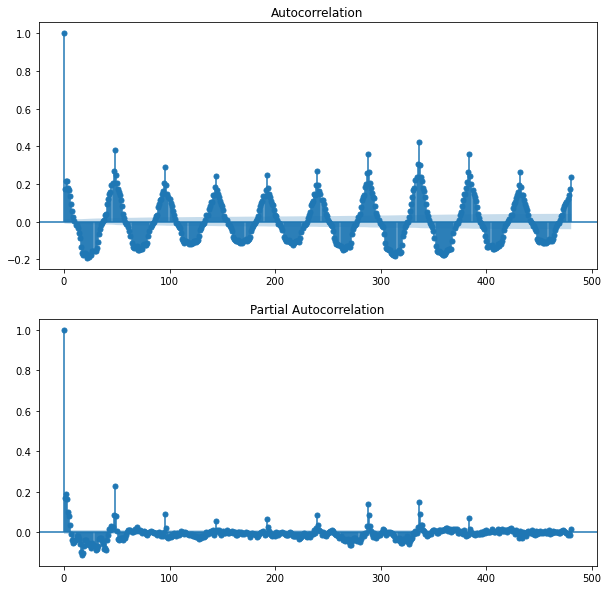

In [8]:
import statsmodels.api as sm

fig,ax = plt.subplots(2,1,figsize=(10,10))
fig = sm.graphics.tsa.plot_acf(df['HH Electricity (kWh)'].diff().dropna(), lags=480, ax=ax[0])
fig = sm.graphics.tsa.plot_pacf(df['HH Electricity (kWh)'].diff().dropna(), lags=480, ax=ax[1])
plt.show()

In [19]:
exogenous = df[['dayofweek','hour','holiday','month','Temperature (C)','Feels like (C)','Humidity (%)']]

modeltuning = auto_arima(df['HH Electricity (kWh)'], X = exogenous ,trace = True)

modeltuning.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=106462.335, Time=92.32 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=212532.810, Time=34.78 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=106790.150, Time=45.68 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=174552.366, Time=59.98 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222176.458, Time=21.09 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=105406.241, Time=101.95 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=151580.797, Time=92.69 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=106321.327, Time=65.67 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=104755.819, Time=81.02 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=140667.476, Time=87.16 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=102102.405, Time=93.04 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=102250.879, Time=98.53 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=102202.676, Time=99.08 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=104321.023, Time=

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35040
Model:               SARIMAX(2, 0, 3)   Log Likelihood              -51037.202
Date:                Mon, 24 Jan 2022   AIC                         102102.405
Time:                        05:00:57   BIC                         102220.904
Sample:                             0   HQIC                        102140.148
                              - 35040                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.3322      0.010     33.812      0.000       0.313       0.351
dayofweek          -0.0417      0.020     -2.035      0.042      -0.082      -0.002
hour            -2.033e-14   8.29e-11     -0.000      1.000   -1.63e-10    1.63e-10
holiday            -1.9617      0.117    -16.743      0.000      -2.191      -1.732
month              -0.2038      0.026     -7.799      0.000      -0.255      -0.153
Temperature (C)    -0.1578      0.023     -6.911      0.000      -0.203      -0.113
Feels like (C)      0.0452      0.016      2.752      0.006       0.013       0.077
Humidity (%)       -0.0254      0.003     -8.155      0.000      -0.031      -0.019
ar.L1               1.8969      0.004    436.676      0.000       1.888       1.905
ar.L2              -0.9121      0.004   -218.248      0.000      -0.920      -0.904
ma.L1              -0.8799      0.006   -141.603      0.000      -0.892      -0.868
ma.L2               0.0785      0.005     14.962      0.000       0.068       0.089
ma.L3               0.0526      0.005     11.599      0.000       0.044       0.061
sigma2              1.0868      0.005    213.573      0.000       1.077       1.097
===================================================================================
Ljung-Box (L1) (Q):                   0.22   Jarque-Bera (JB):             34949.70
Prob(Q):                              0.64   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.75e+18. Standard errors may be unstable.
"""

In [20]:
modeltuning2 = auto_arima(df['HH Electricity (kWh)'], X = exogenous ,trace = True, start_p=4, start_q=4, max_p=10, max_q=10, max_order=None)            

modeltuning2.summary()




Performing stepwise search to minimize aic
 ARIMA(4,0,4)(0,0,0)[0] intercept   : AIC=102243.971, Time=117.49 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=212532.810, Time=34.97 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=106790.150, Time=47.17 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=174552.366, Time=58.21 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222176.458, Time=18.03 sec
 ARIMA(3,0,4)(0,0,0)[0] intercept   : AIC=102184.448, Time=109.17 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=102202.676, Time=100.49 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=102250.879, Time=102.65 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=102136.986, Time=112.13 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=102273.613, Time=109.39 sec
 ARIMA(4,0,5)(0,0,0)[0] intercept   : AIC=102160.471, Time=126.13 sec
 ARIMA(3,0,6)(0,0,0)[0] intercept   : AIC=102062.520, Time=134.12 sec
 ARIMA(2,0,6)(0,0,0)[0] intercept   : AIC=102218.463, Time=134.41 sec
 ARIMA(4,0,6)(0,0,0)[0] intercept   : AIC=102283.45

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35040
Model:               SARIMAX(3, 0, 6)   Log Likelihood              -51013.260
Date:                Mon, 24 Jan 2022   AIC                         102062.520
Time:                        05:50:12   BIC                         102214.876
Sample:                             0   HQIC                        102111.046
                              - 35040                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.5118      0.022     23.112      0.000       0.468       0.555
dayofweek          -0.0476      0.021     -2.291      0.022      -0.088      -0.007
hour            -2.033e-14   2.68e-10  -7.57e-05      1.000   -5.26e-10    5.26e-10
holiday            -1.3049      0.163     -8.003      0.000      -1.625      -0.985
month               0.0046      0.026      0.177      0.860      -0.046       0.056
Temperature (C)    -0.0866      0.023     -3.794      0.000      -0.131      -0.042
Feels like (C)     -0.0045      0.016     -0.274      0.784      -0.036       0.028
Humidity (%)       -0.0196      0.003     -6.282      0.000      -0.026      -0.013
ar.L1               0.9892      0.047     20.924      0.000       0.897       1.082
ar.L2               0.8472      0.090      9.460      0.000       0.672       1.023
ar.L3              -0.8625      0.043    -19.902      0.000      -0.947      -0.778
ma.L1               0.0292      0.048      0.616      0.538      -0.064       0.122
ma.L2              -0.7538      0.042    -17.933      0.000      -0.836      -0.671
ma.L3               0.0979      0.006     16.095      0.000       0.086       0.110
ma.L4               0.0235      0.006      4.257      0.000       0.013       0.034
ma.L5               0.0201      0.005      3.910      0.000       0.010       0.030
ma.L6               0.0076      0.006      1.301      0.193      -0.004       0.019
sigma2              1.0814      0.005    213.974      0.000       1.072       1.091
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             34851.88
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+19. Standard errors may be unstable.
"""

In [22]:
modeltuning3 = auto_arima(df['HH Electricity (kWh)'], X = exogenous ,trace = True, start_p=3, start_q=7, max_p=15, max_q=15, max_order=30)            

modeltuning2.summary()

Performing stepwise search to minimize aic
 ARIMA(3,0,7)(0,0,0)[0] intercept   : AIC=102107.692, Time=167.29 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=212532.810, Time=34.43 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=106790.150, Time=49.52 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=174552.366, Time=63.32 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=222176.458, Time=19.89 sec
 ARIMA(2,0,7)(0,0,0)[0] intercept   : AIC=102186.554, Time=153.71 sec
 ARIMA(3,0,6)(0,0,0)[0] intercept   : AIC=102062.520, Time=143.39 sec
 ARIMA(2,0,6)(0,0,0)[0] intercept   : AIC=102218.463, Time=146.57 sec
 ARIMA(3,0,5)(0,0,0)[0] intercept   : AIC=102136.986, Time=125.86 sec
 ARIMA(4,0,6)(0,0,0)[0] intercept   : AIC=102283.451, Time=151.17 sec
 ARIMA(2,0,5)(0,0,0)[0] intercept   : AIC=102273.613, Time=121.02 sec
 ARIMA(4,0,5)(0,0,0)[0] intercept   : AIC=102160.471, Time=137.98 sec
 ARIMA(4,0,7)(0,0,0)[0] intercept   : AIC=102260.279, Time=163.12 sec
 ARIMA(3,0,6)(0,0,0)[0]             : AIC=103581.17

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35040
Model:               SARIMAX(3, 0, 6)   Log Likelihood              -51013.260
Date:                Mon, 24 Jan 2022   AIC                         102062.520
Time:                        07:05:06   BIC                         102214.876
Sample:                             0   HQIC                        102111.046
                              - 35040                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.5118      0.022     23.112      0.000       0.468       0.555
dayofweek          -0.0476      0.021     -2.291      0.022      -0.088      -0.007
hour            -2.033e-14   2.68e-10  -7.57e-05      1.000   -5.26e-10    5.26e-10
holiday            -1.3049      0.163     -8.003      0.000      -1.625      -0.985
month               0.0046      0.026      0.177      0.860      -0.046       0.056
Temperature (C)    -0.0866      0.023     -3.794      0.000      -0.131      -0.042
Feels like (C)     -0.0045      0.016     -0.274      0.784      -0.036       0.028
Humidity (%)       -0.0196      0.003     -6.282      0.000      -0.026      -0.013
ar.L1               0.9892      0.047     20.924      0.000       0.897       1.082
ar.L2               0.8472      0.090      9.460      0.000       0.672       1.023
ar.L3              -0.8625      0.043    -19.902      0.000      -0.947      -0.778
ma.L1               0.0292      0.048      0.616      0.538      -0.064       0.122
ma.L2              -0.7538      0.042    -17.933      0.000      -0.836      -0.671
ma.L3               0.0979      0.006     16.095      0.000       0.086       0.110
ma.L4               0.0235      0.006      4.257      0.000       0.013       0.034
ma.L5               0.0201      0.005      3.910      0.000       0.010       0.030
ma.L6               0.0076      0.006      1.301      0.193      -0.004       0.019
sigma2              1.0814      0.005    213.974      0.000       1.072       1.091
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             34851.88
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+19. Standard errors may be unstable.
"""

In [23]:
modeltuning3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                35040
Model:               SARIMAX(3, 0, 6)   Log Likelihood              -51013.260
Date:                Mon, 24 Jan 2022   AIC                         102062.520
Time:                        08:11:08   BIC                         102214.876
Sample:                             0   HQIC                        102111.046
                              - 35040                                         
Covariance Type:                  opg                                         
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
intercept           0.5118      0.022     23.112      0.000       0.468       0.555
dayofweek          -0.0476      0.021     -2.291      0.022      -0.088      -0.007
hour            -2.033e-14   2.68e-10  -7.57e-05      1.000   -5.26e-10    5.26e-10
holiday            -1.3049      0.163     -8.003      0.000      -1.625      -0.985
month               0.0046      0.026      0.177      0.860      -0.046       0.056
Temperature (C)    -0.0866      0.023     -3.794      0.000      -0.131      -0.042
Feels like (C)     -0.0045      0.016     -0.274      0.784      -0.036       0.028
Humidity (%)       -0.0196      0.003     -6.282      0.000      -0.026      -0.013
ar.L1               0.9892      0.047     20.924      0.000       0.897       1.082
ar.L2               0.8472      0.090      9.460      0.000       0.672       1.023
ar.L3              -0.8625      0.043    -19.902      0.000      -0.947      -0.778
ma.L1               0.0292      0.048      0.616      0.538      -0.064       0.122
ma.L2              -0.7538      0.042    -17.933      0.000      -0.836      -0.671
ma.L3               0.0979      0.006     16.095      0.000       0.086       0.110
ma.L4               0.0235      0.006      4.257      0.000       0.013       0.034
ma.L5               0.0201      0.005      3.910      0.000       0.010       0.030
ma.L6               0.0076      0.006      1.301      0.193      -0.004       0.019
sigma2              1.0814      0.005    213.974      0.000       1.072       1.091
===================================================================================
Ljung-Box (L1) (Q):                   0.16   Jarque-Bera (JB):             34851.88
Prob(Q):                              0.69   Prob(JB):                         0.00
Heteroskedasticity (H):               0.87   Skew:                             0.83
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.60
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.03e+19. Standard errors may be unstable.
"""

We conclude that ARIMAX(3, 0, 6) is the most optimal parameter selection. (S in SARIMAX stands for seasonality and which would be denoted in the second set of parantheses. but since we have (0,0,0) we dont have seasonality thus our model is ARIMAX.

# Evaluating ARIMAX

For evaluating ARIMAX we use the last 3 months of the dataset for testing.



In [87]:
dftrain = df.iloc[:-(3*48)]
dftest = df.iloc[-(3*48):]



In [88]:
trainexogenous = dftrain[['dayofweek','hour','holiday','month','Temperature (C)','Feels like (C)','Humidity (%)']]

model = ARIMA(dftrain['HH Electricity (kWh)'], exog = trainexogenous, order = (3,0,6))

model = model.fit()







MemoryError: Unable to allocate 9.05 GiB for an array with shape (34844, 34844) and data type float64

In [55]:
from sklearn.metrics import mean_absolute_percentage_error

testexogenous = dftest[['dayofweek','hour','holiday','month','Temperature (C)','Feels like (C)','Humidity (%)']]

pred = model.predict(start = len(dftrain), end = (len(dftrain) + len(dftest))
print(pred)








SyntaxError: invalid syntax (<ipython-input-55-b4af122c1b82>, line 6)

In [4]:
feature_cols = ['n-1', 'n-2', 'n-3', 'n-4', 'n-5', 'dayofweek', 'hour', 'month', 'holiday', 'Temperature (C)', 'Feels like (C)', 'Humidity (%)']

X = df[feature_cols] # Features
y = df.Target # Target variable

#from sklearn.model_selection import train_test_split

#X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,random_state=0) #split training:testing 75:25

scaler = StandardScaler() #scaling
X_scaled = scaler.fit_transform(X)
